In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model5
ndbs
Tue Feb  8 23:20:18 PST 2022


# Goal: Compute annual average rate of reduction (AARR) for wasting and stunting, in each scenario

# Load results

In [2]:
results = csr.VivariumResults.cleaned_from_model_spec('5.3.2')
results.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'births',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
results.wasting_state_person_time.scenario.unique()

array(['baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment'],
      dtype=object)

# Compute wasting and stunting prevalence

In [4]:
wasting_prevalence = (
    csr.get_prevalence(results, 'wasting_state', ['year'], multiplier=100)
    .pipe(vp.aggregate_categories, 'wasting_state', csr.wasting_states_by_superstate, append=True)
)
wasting_prevalence

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,mild_child_wasting,20.639356,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,moderate_acute_malnutrition,7.477660,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,severe_acute_malnutrition,1.873702,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,susceptible_to_child_wasting,70.009281,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1436,2023,946,wasting_treatment,no_acute_malnutrition,91.091144,state_person_time,state_person_time,100,prevalence
1437,2024,946,wasting_treatment,no_acute_malnutrition,91.624449,state_person_time,state_person_time,100,prevalence
1438,2025,946,wasting_treatment,no_acute_malnutrition,92.074019,state_person_time,state_person_time,100,prevalence
1439,2026,946,wasting_treatment,no_acute_malnutrition,92.373875,state_person_time,state_person_time,100,prevalence


In [5]:
stunting_prevalence = (
    csr.get_prevalence(results, 'stunting_state', 'year', multiplier=100)
    .pipe(vp.aggregate_categories, 'stunting_state', csr.stunting_states_by_superstate, append=True)
)
stunting_prevalence

,year,input_draw,scenario,stunting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,29,baseline,cat1,16.890041,state_person_time,state_person_time,100,prevalence
1,2022,29,baseline,cat2,17.604816,state_person_time,state_person_time,100,prevalence
2,2022,29,baseline,cat3,19.781513,state_person_time,state_person_time,100,prevalence
3,2022,29,baseline,cat4,45.723630,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1436,2023,946,wasting_treatment,stunted,34.663156,state_person_time,state_person_time,100,prevalence
1437,2024,946,wasting_treatment,stunted,34.778292,state_person_time,state_person_time,100,prevalence
1438,2025,946,wasting_treatment,stunted,34.743118,state_person_time,state_person_time,100,prevalence
1439,2026,946,wasting_treatment,stunted,34.829221,state_person_time,state_person_time,100,prevalence


# Filter to total wasting and total stunting from 2023-2026

In [6]:
start_year = '2023' # Start at 2023 for now since 2022 has a burn-in period
gam_prevalence = wasting_prevalence.query("wasting_state == 'global_acute_malnutrition' and year >= @start_year")
stunted_prevalence = stunting_prevalence.query("stunting_state == 'stunted' and year >= @start_year")
gam_prevalence

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
961,2023,29,baseline,global_acute_malnutrition,8.988464,state_person_time,state_person_time,100,prevalence
962,2024,29,baseline,global_acute_malnutrition,8.964807,state_person_time,state_person_time,100,prevalence
963,2025,29,baseline,global_acute_malnutrition,8.811893,state_person_time,state_person_time,100,prevalence
964,2026,29,baseline,global_acute_malnutrition,8.867149,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1431,2023,946,wasting_treatment,global_acute_malnutrition,8.908856,state_person_time,state_person_time,100,prevalence
1432,2024,946,wasting_treatment,global_acute_malnutrition,8.375551,state_person_time,state_person_time,100,prevalence
1433,2025,946,wasting_treatment,global_acute_malnutrition,7.925981,state_person_time,state_person_time,100,prevalence
1434,2026,946,wasting_treatment,global_acute_malnutrition,7.626125,state_person_time,state_person_time,100,prevalence


# Filter to single scenario and draw to make sure we have one value per year

In [7]:
scenario = 'wasting_treatment'
input_draw = 29
gam_prevalence.query("scenario==@scenario and input_draw==@input_draw")

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
991,2023,29,wasting_treatment,global_acute_malnutrition,8.843505,state_person_time,state_person_time,100,prevalence
992,2024,29,wasting_treatment,global_acute_malnutrition,8.375669,state_person_time,state_person_time,100,prevalence
993,2025,29,wasting_treatment,global_acute_malnutrition,7.757446,state_person_time,state_person_time,100,prevalence
994,2026,29,wasting_treatment,global_acute_malnutrition,7.523279,state_person_time,state_person_time,100,prevalence


# Try doing a regression using statsmodels, for a single scenario and draw

Statsmodels documentation: https://www.statsmodels.org/stable/index.html

Patsy documentation: https://patsy.readthedocs.io/en/latest/

R formula mini-language: https://cran.r-project.org/doc/manuals/R-intro.html#Formulae-for-statistical-models

Comparison of Patsy formulas with R formulas: https://patsy.readthedocs.io/en/latest/R-comparison.html

In [8]:
data = gam_prevalence.query("scenario==@scenario and input_draw==@input_draw").astype({'year': int})
regression = smf.ols('np.log(value) ~ year', data=data).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(value)   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     84.36
Date:                Tue, 08 Feb 2022   Prob (F-statistic):             0.0116
Time:                        23:20:24   Log-Likelihood:                 12.879
No. Observations:                   4   AIC:                            -21.76
Df Residuals:                       2   BIC:                            -22.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    115.8135     12.382      9.354      0.0

/ihme/homes/ndbs/miniconda3/envs/ciff-sam-38/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [9]:
# The beta coefficient for 'year' is what we need for the AARR
regression.params

Intercept    115.813461
year          -0.056172
dtype: float64

In [10]:
# This is the AARR
1-np.exp(regression.params['year'])

0.054623636651973784

# Compare predicted wasting prevalence vs. actual prevalence from sim

In [11]:
# Actual wasting prevalence values from sim
data

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
991,2023,29,wasting_treatment,global_acute_malnutrition,8.843505,state_person_time,state_person_time,100,prevalence
992,2024,29,wasting_treatment,global_acute_malnutrition,8.375669,state_person_time,state_person_time,100,prevalence
993,2025,29,wasting_treatment,global_acute_malnutrition,7.757446,state_person_time,state_person_time,100,prevalence
994,2026,29,wasting_treatment,global_acute_malnutrition,7.523279,state_person_time,state_person_time,100,prevalence


In [12]:
# Predicted prevalence values from linear regression on log(prevalence)
np.exp((regression.get_prediction(data['year'])).summary_frame())

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,8.821356,1.011507,8.397599,9.266497,8.169899,9.524760
1,8.339502,1.007518,8.075017,8.612649,7.798369,8.918184
2,7.883968,1.007518,7.633931,8.142195,7.372394,8.431041
3,7.453317,1.011507,7.095277,7.829424,6.902889,8.047635


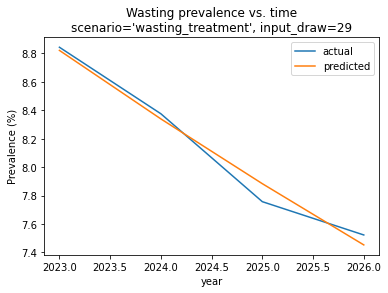

In [13]:
# Plot actual vs. predicted wasting prevalence
plt.plot('year', 'value', data=data, label='actual')
plt.plot(data.year, np.exp(regression.params['Intercept']+regression.params['year']*(data.year)), label="predicted")
plt.title(
    "Wasting prevalence vs. time"
    f"\n{scenario=}, {input_draw=}"
)
plt.ylabel("Prevalence (%)")
plt.xlabel("year")
plt.legend()
plt.show()

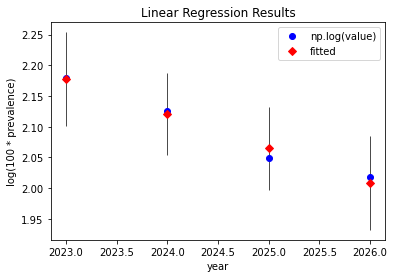

In [14]:
# Plot regression results in log space using built-in statsmodels graphics.plot_fit function
def plot_results(regression, regressor):
    fig, ax = plt.subplots()
    sm.graphics.plot_fit(regression, regressor, ax=ax)
    ax.set_ylabel("log(100 * prevalence)")
    ax.set_xlabel(regressor)
    ax.set_title("Linear Regression Results")
    plt.show()
plot_results(regression, 'year')

In [15]:
# Predicted fraction of predicted initial prevalence
data[['year']].join(
    np.exp(regression.params['year']*(data.year-2023))
    .rename('fraction_of_initial_predicted')
)

,year,fraction_of_initial_predicted
991,2023,1.000000
992,2024,0.945376
993,2025,0.893736
994,2026,0.844917


In [16]:
# Actual fraction of actual initial prevalence
data[['year']].join(
    (data['value'] / data.loc[data.year==2023, 'value'].iloc[0])
    .rename('fraction_of_initial_actual')
)

,year,fraction_of_initial_actual
991,2023,1.000000
992,2024,0.947098
993,2025,0.877191
994,2026,0.850712


In [17]:
data.loc[data.year==2023, 'value'].iloc[0]

8.84350539797395

# Estimate AARR by taking a simple mean of relative reductions

Taking the arithmetic mean of the consecutive relative reductions $(v_{j}-v_{j+1})/v_j$ is eqivalent to taking the arithmetic mean of the consecutive ratios $v_{j+1}/v_{j}$ and subtracting this mean from 1. That is,
$$
\frac{1}{n}\sum_{j=0}^{n-1}\frac{v_{j}-v_{j+1}}{v_j} = 1 - \frac{1}{n}\sum_{j=0}^{n-1}\frac{v_{j+1}}{v_j}.
$$

On the other hand, 1 minus the *geometric* mean of the consecutive ratios, $1-\left(\prod_{j=0}^{n-1} (v_{j+1}/v_{j})\right)^{1/n}$, is equal to $1-(v_{n}/v_{0})^{1/n}$ because the product is telescoping. Thus this estimate only depends on the initial and final values, ignoring the other data points. In contrast to the arithmetic mean, this is *different* from taking the geometric mean of the consecutive relative reductions, $\left(\prod_{j=0}^{n-1} (1-v_{j+1}/v_{j})\right)^{1/n}$, which *does* depend on all the data points.

In [18]:
data['value']

991    8.843505
992    8.375669
993    7.757446
994    7.523279
Name: value, dtype: float64

In [19]:
# Relative reduction over first year
(8.843505 - 8.375669)/8.843505

0.05290164928950683

In [20]:
# Compute relative reduction year-by-year
# The AARR is a kind of average of these numbers
v = data['value'].to_numpy()
relative_reductions = (v[:-1]-v[1:])/v[:-1]
relative_reductions

array([0.05290166, 0.07381178, 0.03018614])

In [21]:
# We should expect the AARR to be somewhat close to this
relative_reductions.mean()

0.05229986069160989

In [22]:
# This is the AARR we got from regression
1-np.exp(regression.params['year'])

0.054623636651973784

In [72]:
# 1 - (arithmetic mean of ratios) = mean of relative reductions from above
1-(v[1:]/v[:-1]).mean()

0.05229986069160997

In [76]:
# Relative decrease from initial point to final point, broken into 3 equal steps
1-(v[-1]/v[0])**(1/3)

0.05246723166835621

In [67]:
# 1 - (geometric mean of ratios) = same as just looking at 1st and last above
1-np.exp(np.log(v[1:]/v[:-1]).mean())

0.05246723166835621

In [77]:
# Geometric mean of relative reductions is smaller than all of the above
np.exp(np.log(1-v[1:]/v[:-1]).mean())

0.04903063741883267

# Write a function to do a regression for each scenario and draw

In [23]:
gam_prevalence.scenario.unique()

array(['baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment'],
      dtype=object)

In [24]:
%%time
def perform_aarr_regessions(prevalence_df):
    possible_worlds = pd.MultiIndex.from_product(
        [prevalence_df.scenario.unique(), prevalence_df.input_draw.unique()],
        names=['scenario', 'input_draw']
    )
    regressions = []
    for scenario, input_draw in possible_worlds:
        data = prevalence_df.query("scenario==@scenario and input_draw==@input_draw").astype({'year': int})
        regressions.append(smf.ols('np.log(value) ~ year', data=data).fit())
    return pd.Series(regressions, index=possible_worlds, name='aarr_regression')

regressions = perform_aarr_regessions(gam_prevalence)
regressions

CPU times: user 460 ms, sys: 5.55 ms, total: 466 ms
Wall time: 468 ms


scenario           input_draw
baseline           29            <statsmodels.regression.linear_model.Regressio...
                   223           <statsmodels.regression.linear_model.Regressio...
                   232           <statsmodels.regression.linear_model.Regressio...
                   357           <statsmodels.regression.linear_model.Regressio...
                                                       ...                        
wasting_treatment  650           <statsmodels.regression.linear_model.Regressio...
                   680           <statsmodels.regression.linear_model.Regressio...
                   829           <statsmodels.regression.linear_model.Regressio...
                   946           <statsmodels.regression.linear_model.Regressio...
Name: aarr_regression, Length: 48, dtype: object

In [25]:
type(regression)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [26]:
def get_beta_and_aarr(regressions, multiplier=1):
    beta = regressions.map(lambda regression: regression.params['year']).rename('beta_coef')
    aarr = multiplier*(1-np.exp(beta)).rename('value')
    aarr_df = (
        pd.concat([beta, aarr], axis=1).reset_index()
        .assign(multiplier=multiplier, measure='aarr')
    )
    return aarr_df

aarr_df = get_beta_and_aarr(regressions, 100)
aarr_df

,scenario,input_draw,beta_coef,value,multiplier,measure
0,baseline,29,-0.005797,0.578027,100,aarr
1,baseline,223,-0.000481,0.048099,100,aarr
2,baseline,232,0.001370,-0.137097,100,aarr
3,baseline,357,-0.001074,0.107392,100,aarr
...,...,...,...,...,...,...
44,wasting_treatment,650,-0.061192,5.935714,100,aarr
45,wasting_treatment,680,-0.048065,4.692806,100,aarr
46,wasting_treatment,829,-0.044746,4.375936,100,aarr
47,wasting_treatment,946,-0.052157,5.082006,100,aarr


# Write a function to plot a bar chart showing the AARRs for each scenario

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,0.267728,0.314993,-0.158046,-0.152285,0.221576,0.711611,0.725027
wasting_treatment,12.0,4.890069,0.710478,3.731712,3.821064,4.994505,5.921090,5.935714
sqlns,12.0,8.333320,0.915420,6.822889,6.873753,8.275765,9.534692,9.549148
lbwsg_interventions,12.0,8.322998,0.913500,6.822454,6.870325,8.267630,9.522669,9.533849


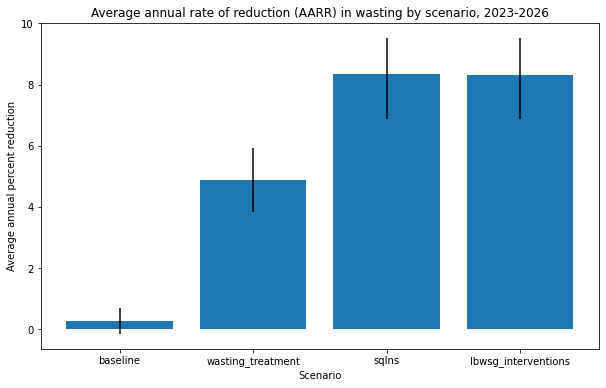

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
def aarr_bar_chart(aarr_df, ylabel='', title='', ax=None):
    if ax is None:
        ax = plt.gca()
    aarr_df = csr.to_ordered_categoricals(aarr_df)
    summary_df = aarr_df.groupby('scenario')['value'].describe(percentiles=[.025, .975])
    scenarios = summary_df.index
    x = np.arange(len(scenarios))
    ax.bar(
        x, summary_df['mean'], tick_label=scenarios,
        yerr=np.abs(summary_df[['2.5%', '97.5%']].T - summary_df['mean']).to_numpy()
    )
    ax.set_xlabel('Scenario')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return summary_df

summary = aarr_bar_chart(
    aarr_df,
    ylabel="Average annual percent reduction",
    title=("Average annual rate of reduction (AARR) in wasting by scenario"
    f", {gam_prevalence.year.min()}-{gam_prevalence.year.max()}")
)
summary

In [28]:
summary[['2.5%', '97.5%']].T

scenario,baseline,wasting_treatment,sqlns,lbwsg_interventions
2.5%,-0.152285,3.821064,6.873753,6.870325
97.5%,0.711611,5.921090,9.534692,9.522669


In [29]:
np.abs(summary[['2.5%', '97.5%']].T - summary['mean'])

scenario,baseline,wasting_treatment,sqlns,lbwsg_interventions
2.5%,0.420013,1.069005,1.459567,1.452673
97.5%,0.443883,1.031021,1.201373,1.199671


# Do computations for stunting

In [30]:
stunting_regressions = perform_aarr_regessions(stunted_prevalence)
stunting_aarr_df = get_beta_and_aarr(stunting_regressions, multiplier=100)
stunting_aarr_df

,scenario,input_draw,beta_coef,value,multiplier,measure
0,baseline,29,0.001431,-0.143244,100,aarr
1,baseline,223,-0.000233,0.023315,100,aarr
2,baseline,232,-0.000516,0.051615,100,aarr
3,baseline,357,0.001515,-0.151663,100,aarr
...,...,...,...,...,...,...
44,wasting_treatment,650,0.001518,-0.151896,100,aarr
45,wasting_treatment,680,-0.001363,0.136248,100,aarr
46,wasting_treatment,829,0.002693,-0.269634,100,aarr
47,wasting_treatment,946,0.001333,-0.133351,100,aarr


,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,-0.102920,0.115467,-0.268221,-0.251358,-0.138846,0.113278,0.136667
wasting_treatment,12.0,-0.103551,0.115795,-0.269634,-0.252349,-0.139389,0.112811,0.136248
sqlns,12.0,2.893398,0.887666,1.731696,1.744431,2.979163,4.284140,4.460175
lbwsg_interventions,12.0,2.895045,0.887294,1.734308,1.747918,2.981415,4.287764,4.464892


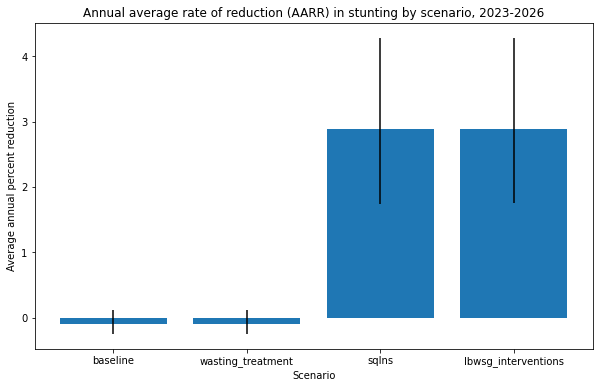

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
aarr_bar_chart(
    stunting_aarr_df,
    ylabel="Average annual percent reduction",
    title=("Annual average rate of reduction (AARR) in stunting by scenario"
    f", {stunted_prevalence.year.min()}-{stunted_prevalence.year.max()}"),
    ax=ax
)

# Try a scatter plot to better see the uncertainty

In [32]:
aarr_df

,scenario,input_draw,beta_coef,value,multiplier,measure
0,baseline,29,-0.005797,0.578027,100,aarr
1,baseline,223,-0.000481,0.048099,100,aarr
2,baseline,232,0.001370,-0.137097,100,aarr
3,baseline,357,-0.001074,0.107392,100,aarr
...,...,...,...,...,...,...
44,wasting_treatment,650,-0.061192,5.935714,100,aarr
45,wasting_treatment,680,-0.048065,4.692806,100,aarr
46,wasting_treatment,829,-0.044746,4.375936,100,aarr
47,wasting_treatment,946,-0.052157,5.082006,100,aarr


In [33]:
scenarios = aarr_df.scenario.unique()
draws = aarr_df.input_draw.unique()
scenarios

array(['baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment'],
      dtype=object)

In [34]:
list(enumerate(scenarios))

[(0, 'baseline'),
 (1, 'lbwsg_interventions'),
 (2, 'sqlns'),
 (3, 'wasting_treatment')]

In [35]:
np.arange(len(scenarios))

array([0, 1, 2, 3])

In [36]:
list(zip(*enumerate(scenarios)))

[(0, 1, 2, 3),
 ('baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment')]

In [37]:
print(*zip(*enumerate(scenarios)))

(0, 1, 2, 3) ('baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment')


In [38]:
list(map(list, zip(*enumerate(scenarios))))

[[0, 1, 2, 3],
 ['baseline', 'lbwsg_interventions', 'sqlns', 'wasting_treatment']]

In [39]:
aarr_df.scenario.map({scenario: i for i, scenario in enumerate(scenarios)})

0     0
1     0
2     0
3     0
     ..
44    3
45    3
46    3
47    3
Name: scenario, Length: 48, dtype: int64

value  xtick    jitter         x
scenario          input_draw                                     
baseline          29          0.578027      0 -0.012125 -0.012125
                  223         0.048099      0 -0.011199 -0.011199
                  232        -0.137097      0  0.024837  0.024837
                  357         0.107392      0  0.046155  0.046155
...                                ...    ...       ...       ...
wasting_treatment 650         5.935714      1  0.015062  1.015062
                  680         4.692806      1 -0.043187  0.956813
                  829         4.375936      1 -0.044536  0.955464
                  946         5.082006      1  0.026882  1.026882

[48 rows x 4 columns]

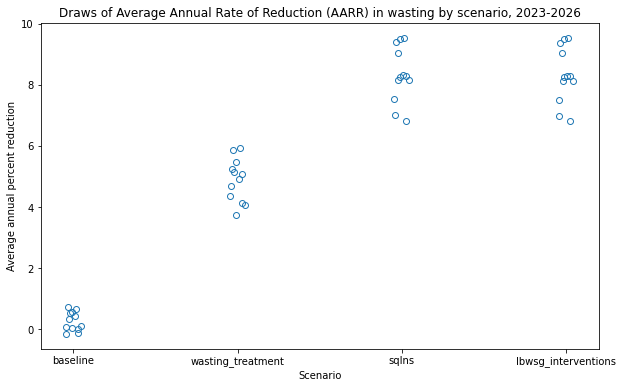

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

## This version uses a different random jitter for every row (#rows = #scenarios x #draws)
##
# def aarr_bar_scatter0(df, ylabel='', title='', seed=8421, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     rng = np.random.default_rng(seed)
#     df = csr.to_ordered_categoricals(df)
#     scenarios = df.scenario.unique().sort_values()
# #     print(scenarios)
#     x = df.scenario.map({scenario: i for i, scenario in enumerate(scenarios)}).astype(int)
# #     print(x)
#     width=0.05
#     jitter = rng.uniform(-width/2, width/2, len(x))
# #     print(jitter)
#     ax.plot(x+jitter, df['value'], 'o')
#     xticks, xtick_labels = zip(*enumerate(scenarios))
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xtick_labels)
#     ax.set_ylabel(ylabel)
#     ax.set_title(title)

## This version uses the same random jitter for the same draw in each scenario,
## so that identical results will appear identical in the graph.
##
def aarr_bar_scatter(df, ylabel='', title='', jitter_width=0.1, seed=8421, ax=None, **plot_kwargs):
    if ax is None:
        ax = plt.gca()
    rng = np.random.default_rng(seed)
    df = csr.to_ordered_categoricals(df)
    plot_df = df[['scenario', 'input_draw', 'value']].set_index(['scenario', 'input_draw'])
    scenarios = plot_df.index.unique('scenario').sort_values()
    draws = plot_df.index.unique('input_draw') # Retains index name, needed for joining

    plot_df['xtick'] = (
        plot_df.index
        .get_level_values('scenario')
        .map({scenario: i for i, scenario in enumerate(scenarios)}).astype(int)
    )
    jitter = pd.Series(rng.uniform(-jitter_width/2, jitter_width/2, len(draws)), index=draws, name='jitter')
    # Join indices on 'input_draw' to broadcast each draw's jitter to all scenarios
    plot_df = plot_df.join(jitter)
    plot_df['x'] = plot_df['xtick'] + plot_df['jitter']
    
    ax.plot('x', 'value', 'o', markerfacecolor='none', data=plot_df, **plot_kwargs)
    xticks, xtick_labels = zip(*enumerate(scenarios))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel('Scenario')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return plot_df

df = aarr_bar_scatter(
    aarr_df,
    ylabel="Average annual percent reduction",
    title=("Draws of Average Annual Rate of Reduction (AARR) in wasting by scenario"
    f", {gam_prevalence.year.min()}-{gam_prevalence.year.max()}"),
    ax=ax
)
df

In [41]:
df.index.unique('input_draw')

Int64Index([29, 223, 232, 357, 394, 524, 602, 629, 650, 680, 829, 946], dtype='int64', name='input_draw')

In [42]:
df.index.unique('scenario').sort_values()

CategoricalIndex(['baseline', 'wasting_treatment', 'sqlns',
                  'lbwsg_interventions'],
                 categories=['baseline', 'wasting_treatment', 'sqlns', 'lbwsg_interventions'], ordered=True, dtype='category', name='scenario')

In [43]:
df.jitter.unique()

array([-0.0121245 , -0.01119923,  0.02483657,  0.04615455, -0.02029377,
       -0.03377731, -0.02529221,  0.00646672,  0.01506156, -0.04318706,
       -0.04453618,  0.02688237])

value  xtick    jitter         x
scenario          input_draw                                     
baseline          29         -0.143244      0 -0.012125 -0.012125
                  223         0.023315      0 -0.011199 -0.011199
                  232         0.051615      0  0.024837  0.024837
                  357        -0.151663      0  0.046155  0.046155
...                                ...    ...       ...       ...
wasting_treatment 650        -0.151896      1  0.015062  1.015062
                  680         0.136248      1 -0.043187  0.956813
                  829        -0.269634      1 -0.044536  0.955464
                  946        -0.133351      1  0.026882  1.026882

[48 rows x 4 columns]

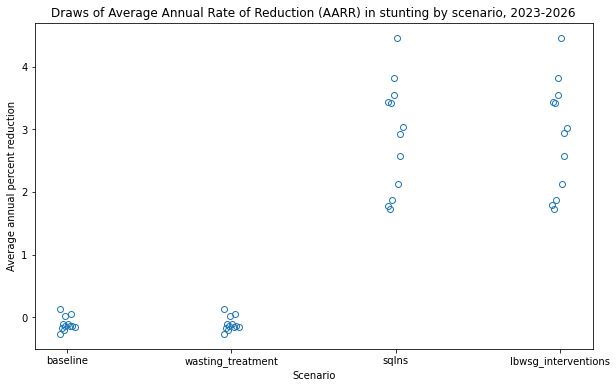

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
aarr_bar_scatter(
    stunting_aarr_df,
    ylabel="Average annual percent reduction",
    title=("Draws of Average Annual Rate of Reduction (AARR) in stunting by scenario"
    f", {stunted_prevalence.year.min()}-{stunted_prevalence.year.max()}"),
)

# Test some pandas stuff

Apparently pandas broadcasting works over rows but not columns.

In [45]:
d = pd.DataFrame(
    {'a': [1,2,3],
     'b': [4,5,6],
     'c': [7,8,9],
    }
)
d

,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9


In [46]:
d[['a', 'b']]

,a,b
0,1,4
1,2,5
2,3,6


In [47]:
d[['a', 'b']].T + d['c']

,0,1,2
a,8,10,12
b,11,13,15


In [48]:
d[['a', 'b']] + d['c']

,a,b,0,1,2
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


In [49]:
d.T+d['a']

,0,1,2
a,2,4,6
b,5,7,9
c,8,10,12


# Compare regression AARR computation with naive average

In [50]:
gam_prevalence

,year,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
961,2023,29,baseline,global_acute_malnutrition,8.988464,state_person_time,state_person_time,100,prevalence
962,2024,29,baseline,global_acute_malnutrition,8.964807,state_person_time,state_person_time,100,prevalence
963,2025,29,baseline,global_acute_malnutrition,8.811893,state_person_time,state_person_time,100,prevalence
964,2026,29,baseline,global_acute_malnutrition,8.867149,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...
1431,2023,946,wasting_treatment,global_acute_malnutrition,8.908856,state_person_time,state_person_time,100,prevalence
1432,2024,946,wasting_treatment,global_acute_malnutrition,8.375551,state_person_time,state_person_time,100,prevalence
1433,2025,946,wasting_treatment,global_acute_malnutrition,7.925981,state_person_time,state_person_time,100,prevalence
1434,2026,946,wasting_treatment,global_acute_malnutrition,7.626125,state_person_time,state_person_time,100,prevalence


In [51]:
%%time
# Compute relative reduction year-by-year
# The AARR is a kind of average of these numbers
# v = df['value'].to_numpy()
# relative_reductions = (v[:-1]-v[1:])/v[:-1]
# relative_reductions
def compute_mean_consecutive_relative_reductions(prevalence_df):
    possible_worlds = pd.MultiIndex.from_product(
        [prevalence_df.scenario.unique(), prevalence_df.input_draw.unique()],
        names=['scenario', 'input_draw']
    )
    average_reductions = []
    for scenario, input_draw in possible_worlds:
        data = prevalence_df.query("scenario==@scenario and input_draw==@input_draw").astype({'year': int})
        values = data['value'].array
        relative_reductions = (values[:-1]-values[1:])/values[:-1]
        average_reductions.append(relative_reductions.mean())
    return pd.Series(average_reductions, index=possible_worlds, name='aarr_naive') 

naive_aarr = compute_mean_consecutive_relative_reductions(gam_prevalence)
naive_aarr

CPU times: user 224 ms, sys: 15.6 ms, total: 240 ms
Wall time: 258 ms


scenario           input_draw
baseline           29            0.004473
                   223           0.000340
                   232          -0.002246
                   357           0.001888
                                   ...   
wasting_treatment  650           0.058560
                   680           0.044174
                   829           0.043467
                   946           0.050457
Name: aarr_naive, Length: 48, dtype: float64

In [90]:
%%time

def regression_slope(x,y):
    """Computes the slope of the OLS regression line for the data points defined by the arrays (x,y)."""
    xmean, ymean = x.mean(), y.mean()
    beta = ((x-xmean)*(y-ymean)).sum()/((x-xmean)**2).sum()
    return beta

def slopes_between_all_pairs(x,y):
    """"Returns an array of slopes between each pair of points (x[i],y[i]), (x[j],y[j]).
    x and y must be arrays of the same length.
    """
    n = len(x)
    if len(y) != n:
        raise ValueError("arrays must have same length")
    slopes = np.empty(n*(n-1)//2)
    for i in range(n):
        for j in range(i+1, n):
            slopes[i+j*(j-1)//2] = (y[j]-y[i])/(x[j]-x[i])
    return slopes

def consecutive_relative_reductions(values):
    return (values[:-1]-values[1:])/values[:-1]

def consecutive_relative_ratios(values):
    return values[1:]/values[:-1]

def compute_average_relative_reductions(prevalence_df):
    def aarr_from_regression_slope(values):
        x = np.arange(len(values)) # x coordinates are consecutive years, start year doesn't matter
        beta = regression_slope(x, np.log(values))
        return 1-np.exp(beta)
        
    def mean_consecutive_relative_reduction(values):
        return consecutive_relative_reductions(values.array).mean()
    
    def rms_consecutive_relative_reduction(values):
        """Computes the root mean square of the relative reductions in values."""
        return np.sqrt(((consecutive_relative_reductions(values.array))**2).mean())
    
    def geometric_mean_consecutive_relative_reduction(values):
        relative_reductions = consecutive_relative_reductions(values.array)
        if (relative_reductions > 0).all():
            return np.exp(np.log(relative_reductions).mean())
        else:
            return np.nan
        
    def exp_mean_consecutive_relative_reduction(values):
        return np.log(np.exp(consecutive_relative_reductions(values.array)).mean())
    
    def aarr_from_geometric_mean_consecutive_ratio(values):
        """This depends only on initial and final values."""
        values = values.array
        return 1-(values[-1]/values[0])**(1/(len(values)-1))
    
    def aarr_from_mean_of_all_slopes(values):
        x = np.arange(len(values)) # x coordinates are consecutive years, start year doesn't matter
        slopes = slopes_between_all_pairs(x, np.log(values.array))
        return 1-np.exp(slopes.mean())
    
    def aarr_from_median_of_all_slopes(values):
        """This is 1 - exp(Theil–Sen estimator)."""
        x = np.arange(len(values)) # x coordinates are consecutive years, start year doesn't matter
        slopes = slopes_between_all_pairs(x, np.log(values.array))
        return 1-np.exp(np.median(slopes))
    
    result = prevalence_df.groupby(['scenario', 'input_draw'])['value'].agg(
        [
            aarr_from_regression_slope,
            mean_consecutive_relative_reduction,
            rms_consecutive_relative_reduction,
            geometric_mean_consecutive_relative_reduction,
            exp_mean_consecutive_relative_reduction,
            aarr_from_geometric_mean_consecutive_ratio,
            aarr_from_mean_of_all_slopes,
            aarr_from_median_of_all_slopes
#             rms_reduction_rate, geometric_mean_reduction_rate, exp_mean_reduction_rate
        ]
    )
    return result

naive_aarr_df = compute_average_relative_reductions(gam_prevalence)
naive_aarr_df

CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 101 ms


aarr_from_regression_slope  \
scenario          input_draw                               
baseline          29                            0.005780   
                  223                           0.000481   
                  232                          -0.001371   
                  357                           0.001074   
...                                                  ...   
wasting_treatment 650                           0.059357   
                  680                           0.046928   
                  829                           0.043759   
                  946                           0.050820   

                              mean_consecutive_relative_reduction  \
scenario          input_draw                                        
baseline          29                                     0.004473   
                  223                                    0.000340   
                  232                                   -0.002246   
                  357                                    0.001888   
...                                                           ...   
wasting_treatment 650                                    0.058560   
                  680                                    0.044174   
                  829                                    0.043467   
                  946                                    0.050457   

                              rms_consecutive_relative_reduction  \
scenario          input_draw                                       
baseline          29                                    0.010602   
                  223                                   0.008425   
                  232                                   0.013463   
                  357                                   0.009256   
...                                                          ...   
wasting_treatment 650                                   0.060339   
                  680                                   0.049024   
                  829                                   0.043635   
                  946                                   0.051303   

                              geometric_mean_consecutive_relative_reduction  \
scenario          input_draw                                                  
baseline          29                                                    NaN   
                  223                                                   NaN   
                  232                                                   NaN   
                  357                                                   NaN   
...                                                                     ...   
wasting_treatment 650                                              0.056500   
                  680                                              0.038045   
                  829                                              0.043291   
                  946                                              0.049537   

                              exp_mean_consecutive_relative_reduction  \
scenario          input_draw                                            
baseline          29                                         0.004519   
                  223                                        0.000375   
                  232                                       -0.002159   
                  357                                        0.001929   
...                                                               ...   
wasting_treatment 650                                        0.058665   
                  680                                        0.044400   
                  829                                        0.043474   
                  946                                        0.050500   

                              aarr_from_geometric_mean_consecutive_ratio  \
scenario          input_draw                                               
baseline          29              

In [80]:
(naive_aarr_df['mean_consecutive_relative_reduction'] == naive_aarr).all()

True

In [92]:
aarr_comparison_df = (100*naive_aarr_df).join(aarr_df.set_index(['scenario', 'input_draw'])['value'].rename('aarr'))
aarr_comparison_df

aarr_from_regression_slope  \
scenario          input_draw                               
baseline          29                            0.578027   
                  223                           0.048099   
                  232                          -0.137097   
                  357                           0.107392   
...                                                  ...   
wasting_treatment 650                           5.935714   
                  680                           4.692806   
                  829                           4.375936   
                  946                           5.082006   

                              mean_consecutive_relative_reduction  \
scenario          input_draw                                        
baseline          29                                     0.447283   
                  223                                    0.034003   
                  232                                   -0.224639   
                  357                                    0.188818   
...                                                           ...   
wasting_treatment 650                                    5.855971   
                  680                                    4.417437   
                  829                                    4.346681   
                  946                                    5.045696   

                              rms_consecutive_relative_reduction  \
scenario          input_draw                                       
baseline          29                                    1.060183   
                  223                                   0.842461   
                  232                                   1.346269   
                  357                                   0.925563   
...                                                          ...   
wasting_treatment 650                                   6.033948   
                  680                                   4.902414   
                  829                                   4.363475   
                  946                                   5.130280   

                              geometric_mean_consecutive_relative_reduction  \
scenario          input_draw                                                  
baseline          29                                                    NaN   
                  223                                                   NaN   
                  232                                                   NaN   
                  357                                                   NaN   
...                                                                     ...   
wasting_treatment 650                                              5.649953   
                  680                                              3.804477   
                  829                                              4.329089   
                  946                                              4.953732   

                              exp_mean_consecutive_relative_reduction  \
scenario          input_draw                                            
baseline          29                                         0.451906   
                  223                                        0.037544   
                  232                                       -0.215856   
                  357                                        0.192931   
...                                                               ...   
wasting_treatment 650                                        5.866521   
                  680                                        4.440016   
                  829                                        4.347412   
                  946                                        5.049993   

                              aarr_from_geometric_mean_consecutive_ratio  \
scenario          input_draw                                               
baseline          29              

In [86]:
np.allclose(aarr_comparison_df['aarr_from_regression_slope'], aarr_comparison_df['aarr'])

True

In [82]:
aarr_comparison_df['aarr']-aarr_comparison_df['mean_consecutive_relative_reduction']

scenario           input_draw
baseline           29            0.130744
                   223           0.014096
                   232           0.087542
                   357          -0.081427
                                   ...   
wasting_treatment  650           0.079743
                   680           0.275369
                   829           0.029255
                   946           0.036310
Length: 48, dtype: float64

In [83]:
aarr_df.set_index(['scenario', 'input_draw'])['value']-100*naive_aarr

scenario           input_draw
baseline           29            0.130744
                   223           0.014096
                   232           0.087542
                   357          -0.081427
                                   ...   
wasting_treatment  650           0.079743
                   680           0.275369
                   829           0.029255
                   946           0.036310
Length: 48, dtype: float64

value  xtick    jitter         x
scenario          input_draw                                     
baseline          29          0.130744      0 -0.012125 -0.012125
                  223         0.014096      0 -0.011199 -0.011199
                  232         0.087542      0  0.024837  0.024837
                  357        -0.081427      0  0.046155  0.046155
...                                ...    ...       ...       ...
wasting_treatment 650         0.079743      1  0.015062  1.015062
                  680         0.275369      1 -0.043187  0.956813
                  829         0.029255      1 -0.044536  0.955464
                  946         0.036310      1  0.026882  1.026882

[48 rows x 4 columns]

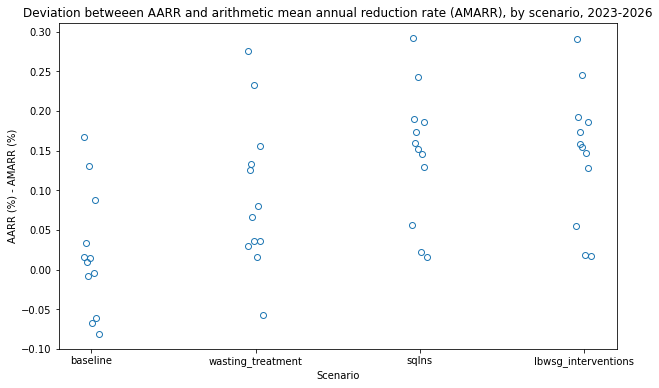

In [84]:
fig, ax = plt.subplots(figsize=(10,6))
aarr_bar_scatter(
    (aarr_comparison_df['aarr']-aarr_comparison_df['mean_consecutive_relative_reduction']
    ).rename('value').reset_index(),
    ylabel="AARR (%) - AMARR (%)",
    title=("Deviation betweeen AARR and arithmetic mean annual reduction rate (AMARR), by scenario"
    f", {stunted_prevalence.year.min()}-{stunted_prevalence.year.max()}"),
)

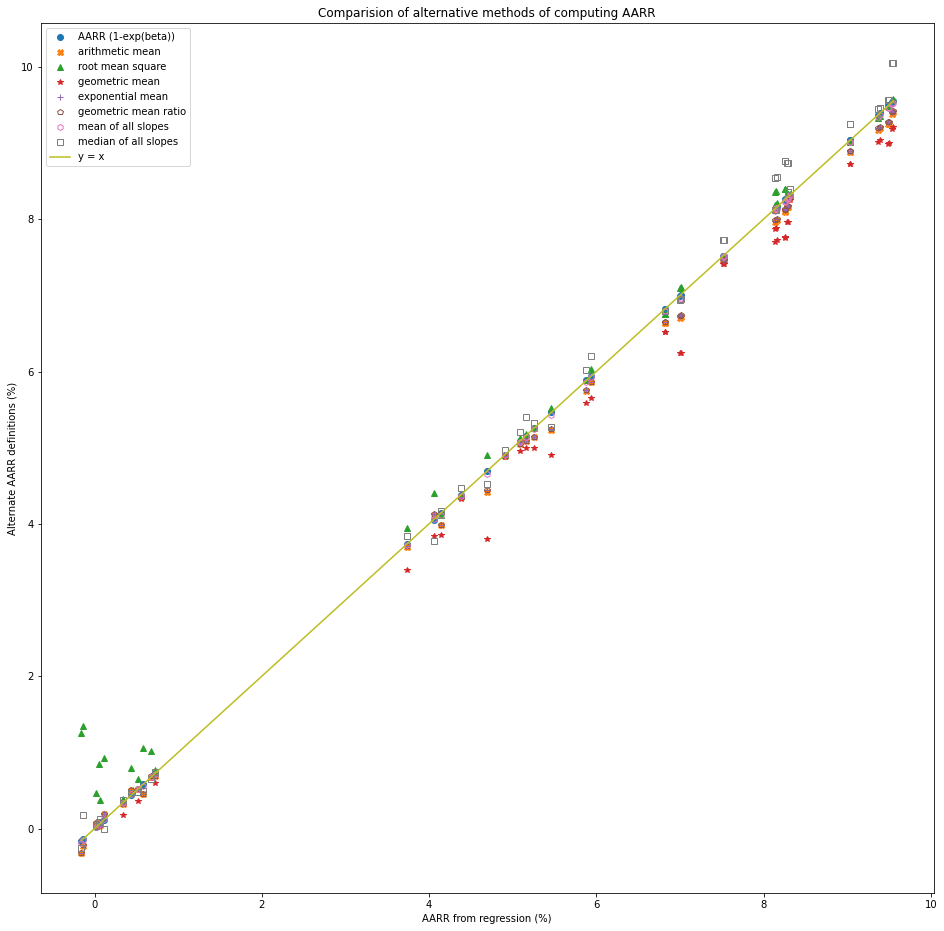

In [107]:
fig, ax = plt.subplots(figsize=(16,16))
"""
aarr_from_regression_slope,
            mean_consecutive_relative_reduction,
            rms_consecutive_relative_reduction,
            geometric_mean_consecutive_relative_reduction,
            exp_mean_consecutive_relative_reduction,
            geometric_mean_consecutive_ratio,
            mean_of_all_slopes,
            median_of_all_slopes
"""
def plot_aarr_comparison(aarr_comparison_df, ax=None):
    if ax is None: ax = plt.gca()
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['aarr'],
            'o', label='AARR (1-exp(beta))')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['mean_consecutive_relative_reduction'],
            'X', label='arithmetic mean')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['rms_consecutive_relative_reduction'],
            '^', label='root mean square')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['geometric_mean_consecutive_relative_reduction'],
            '*', label='geometric mean')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['exp_mean_consecutive_relative_reduction'],
            '+', label='exponential mean')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['aarr_from_geometric_mean_consecutive_ratio'],
            'p', label='geometric mean ratio', markerfacecolor='none')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['aarr_from_mean_of_all_slopes'],
            'h', label='mean of all slopes', markerfacecolor='none')
    ax.plot(aarr_comparison_df['aarr'], aarr_comparison_df['aarr_from_median_of_all_slopes'],
            's', label='median of all slopes', markerfacecolor='none')
    xmin, xmax = aarr_comparison_df.aarr.min(), aarr_comparison_df.aarr.max()
    x = np.linspace(xmin,xmax)
    ax.plot(x,x, label='y = x')
    ax.set_xlabel('AARR from regression (%)')
    ax.set_ylabel('Alternate AARR definitions (%)')
    ax.set_title("Comparision of alternative methods of computing AARR")
    ax.legend()
    
plot_aarr_comparison(aarr_comparison_df, ax=ax)
plt.show()

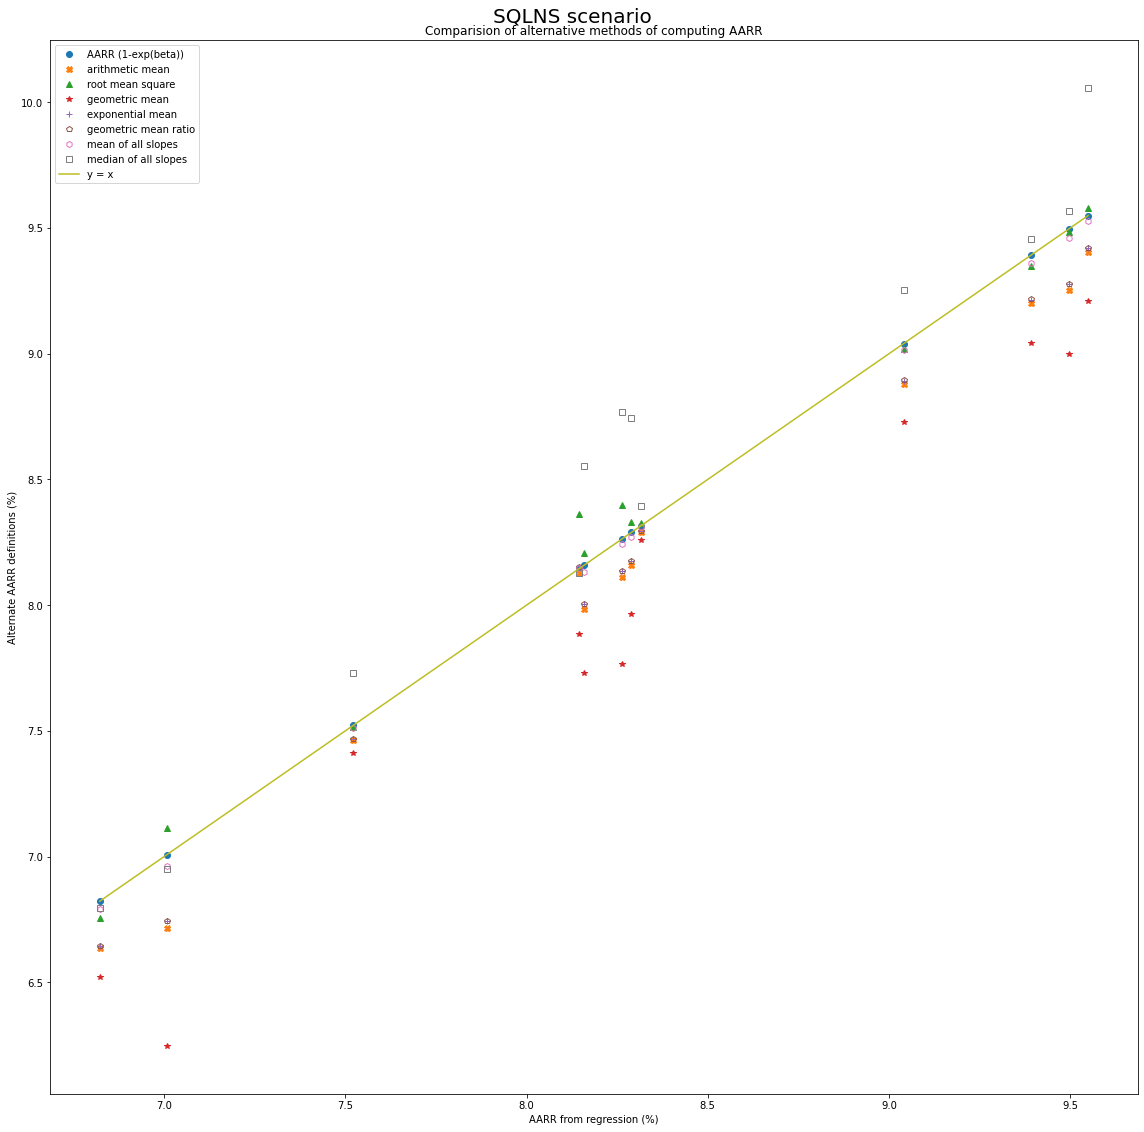

In [114]:
fig, ax = plt.subplots(figsize=(16,16))
# plot_aarr_comparison(aarr_comparison_df.query("6.5<aarr<11"), ax=ax)
plot_aarr_comparison(aarr_comparison_df.query("scenario=='sqlns'"), ax=ax)
fig.suptitle("SQLNS scenario", fontsize = 20)
fig.tight_layout()
plt.show()

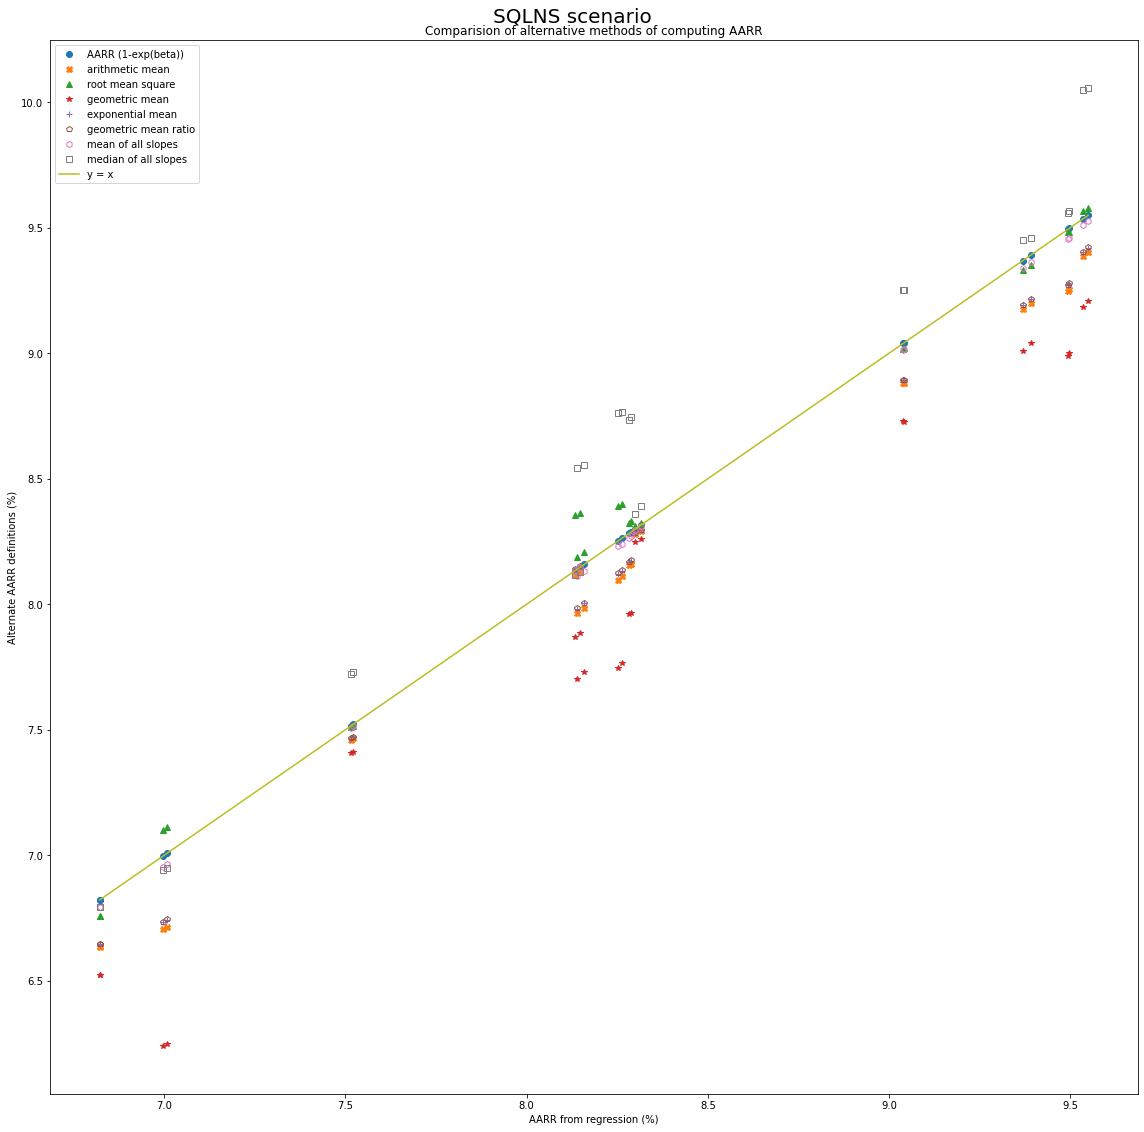

In [115]:
fig, ax = plt.subplots(figsize=(16,16))
plot_aarr_comparison(aarr_comparison_df.query("6.5<aarr<11"), ax=ax)
# plot_aarr_comparison(aarr_comparison_df.query("scenario=='sqlns'"), ax=ax)
fig.suptitle("SQLNS scenario", fontsize = 20)
fig.tight_layout()
plt.show()

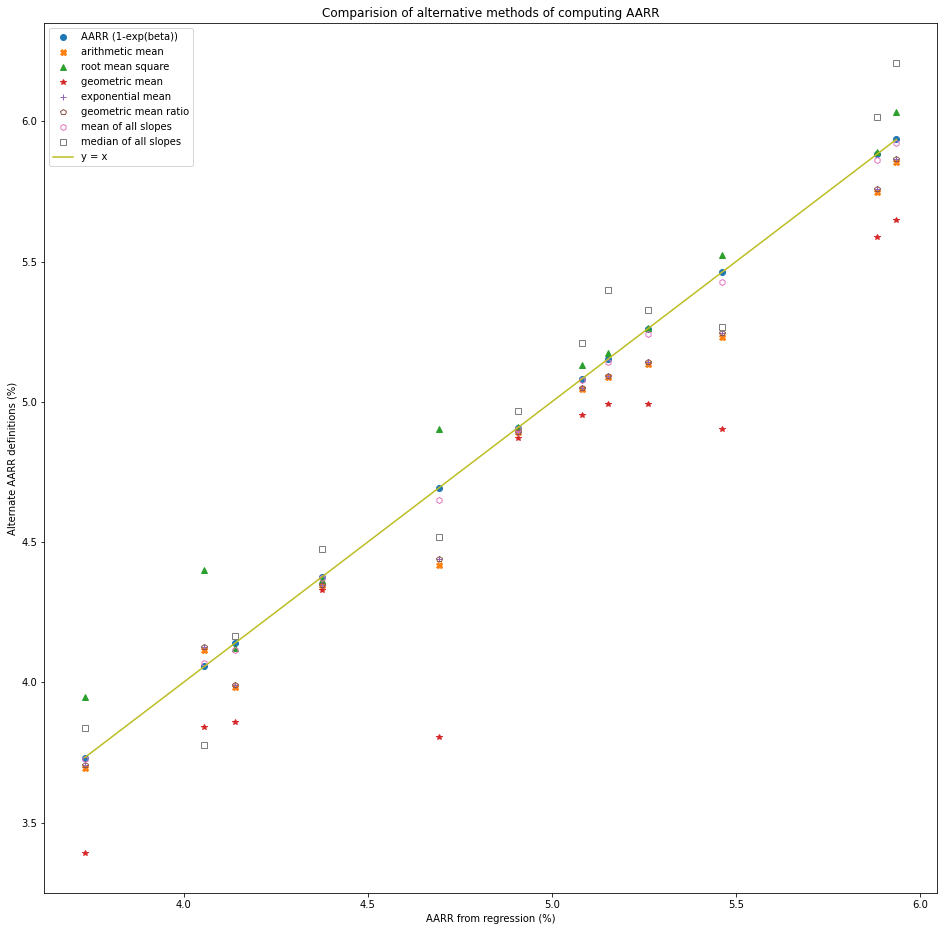

In [109]:
fig, ax = plt.subplots(figsize=(16,16))
plot_aarr_comparison(aarr_comparison_df.query("3<aarr<6.5"), ax=ax)
plt.show()

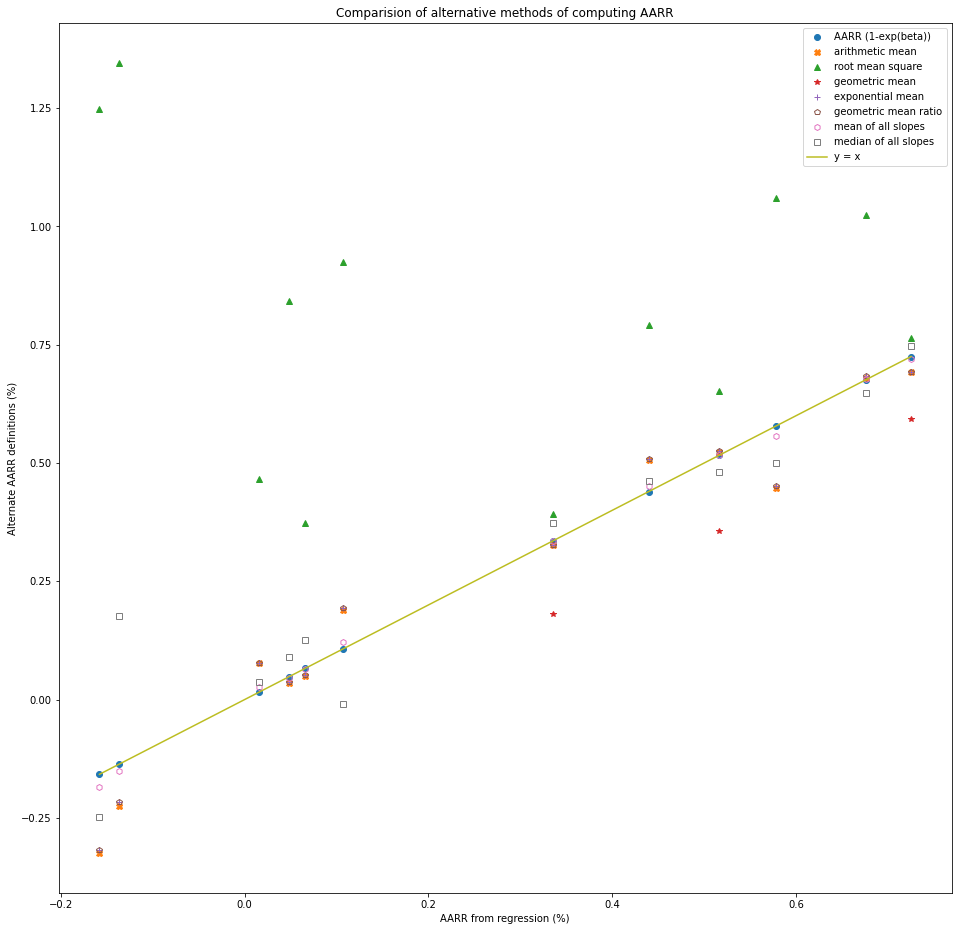

In [110]:
fig, ax = plt.subplots(figsize=(16,16))
plot_aarr_comparison(aarr_comparison_df.query("aarr<2"), ax=ax)
plt.show()